# Importing Required Libraries and Modules

In [ ]:
!pip install torchdiffeq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint
from torchdiffeq import odeint_event

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(str(device) + ' is being used...')

cuda is being used...


# ODE Models

In [ ]:
class ODEFuncTanh(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(7, 50),
                             nn.Tanh(),
                             nn.Linear(50, 7))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

class ODEFuncSig(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(7, 50),
                             nn.Sigmoid(),
                             nn.Linear(50, 7))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

class ODEFuncReLU(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(7, 50),
                             nn.ReLU(),
                             nn.Linear(50, 50),
                             nn.ReLU(),
                             nn.Linear(50, 7))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

class SinAct(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class ODEFuncSinAct(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(7, 50),
                             SinAct(),
                             nn.Linear(50, 7))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

# Point Kinetic Equations - 1
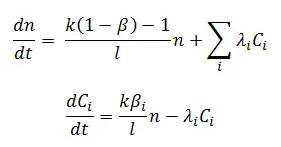

In [ ]:
# Visualizing
def visualize(true_y, pred_y=None):
  fig1 = plt.figure(figsize = (7, 3))
  ax1 = fig1.add_subplot(1, 1, 1)
  ax1.set_title('n vs. t')
  ax1.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'green', label='true trajectory')

  fig2 = plt.figure(figsize = (17, 15))
  ax2 = fig2.add_subplot(6, 6, 1)
  ax2.set_title('C1 vs. t')
  ax2.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')

  ax3 = fig2.add_subplot(6, 6, 2)
  ax3.set_title('C2 vs. t')
  ax3.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 2], 'green', label='true trajectory')

  ax4 = fig2.add_subplot(6, 6, 3)
  ax4.set_title('C3 vs. t')
  ax4.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 3], 'green', label='true trajectory')

  ax5 = fig2.add_subplot(6, 6, 4)
  ax5.set_title('C4 vs. t')
  ax5.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 4], 'green', label='true trajectory')

  ax6 = fig2.add_subplot(6, 6, 5)
  ax6.set_title('C5 vs. t')
  ax6.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 5], 'green', label='true trajectory')

  ax7 = fig2.add_subplot(6, 6, 6)
  ax7.set_title('C6 vs. t')
  ax7.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 6], 'green', label='true trajectory')

  if pred_y is not None:
    ax1.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], 'red', label='prediction')
    ax2.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'red', label='prediction')
    ax3.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 2], 'red', label='prediction')
    ax4.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 3], 'red', label='prediction')
    ax5.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 4], 'red', label='prediction')
    ax6.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 5], 'red', label='prediction')
    ax7.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 6], 'red', label='prediction')

  plt.legend()
  ax1.grid(True)
  ax2.grid(True)
  ax3.grid(True)
  ax4.grid(True)
  ax5.grid(True)
  ax6.grid(True)
  ax7.grid(True)
  plt.show()

# Assigning Value
n  = 100.0
c1, c2, c3, c4, c5, c6 = torch.linspace(0.0008, 0.0023, 6)
print("Values of C: ", c1, c2, c3, c4, c5, c6)
k = 1.005
b1, b2, b3, b4, b5, b6 = 0.000215, 0.001424, 0.001274, 0.002568, 0.000748, 0.000273
l = 0.00022                                                                                 # unit if l is in Seconds(s)
lam1, lam2, lam3, lam4, lam5, lam6 = 0.0124, 0.0305, 0.1111, 0.301, 1.14, 3.01
B = b1 + b2 + b3 + b4 + b5 + b6                                                             # beta

# Computing True Value
data_size = 5000
t = torch.linspace(0., 75., data_size).cuda()
tensor2 = torch.tensor([[(k*(1-B)-1)/l, lam1, lam2, lam3, lam4, lam5, lam6],
                        [k*b1/l, -lam1, 0, 0, 0, 0, 0],
                        [k*b2/l, 0, -lam2, 0, 0, 0, 0],
                        [k*b3/l, 0, 0, -lam3, 0, 0, 0],
                        [k*b4/l, 0, 0, 0, -lam4, 0, 0],
                        [k*b5/l, 0, 0, 0, 0, -lam5, 0],
                        [k*b6/l, 0, 0, 0, 0, 0, -lam6]]).cuda()
tensor2 = tensor2.transpose(0, 1)
# print(tensor2)
# print(tensor1.shape, tensor2.shape)

class Lambda(nn.Module):
  def forward(self, t, y):
    return torch.mm(y, tensor2)

with torch.no_grad():
  true_y = odeint_adjoint(func = Lambda(), y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
#   print(true_y)

visualize(true_y)

# Training
batch_time = 10
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

niters = 400

func = ODEFuncTanh().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

# Evaluating Metrics
print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
end_time = time.time()
time_required = end_time - start_time
print('Process Time: {} secs'.format(time_required))

# Visualing the Predictions
with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

# Point Kinetic Equations - 2
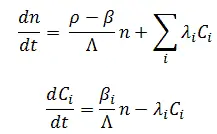

Values of C:  tensor(0.0008) tensor(0.0011) tensor(0.0014) tensor(0.0017) tensor(0.0020) tensor(0.0023)
0.00022110552763819096


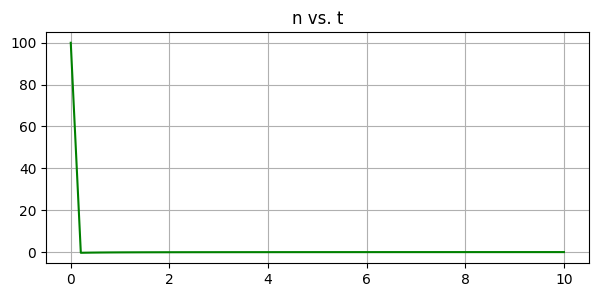

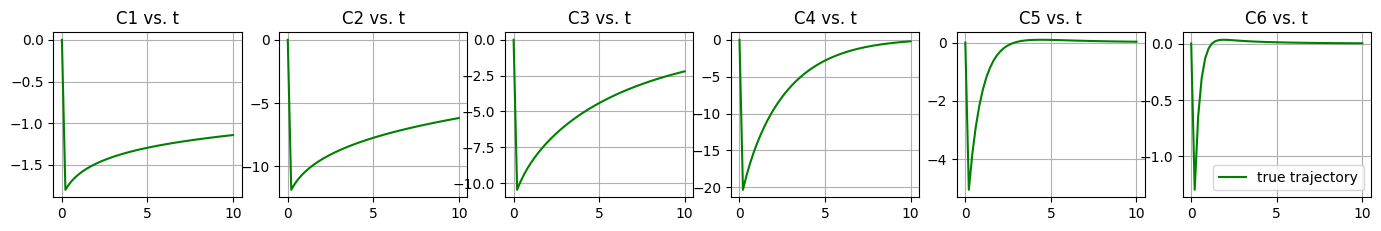

In [ ]:
# Visualizing
def visualize(true_y, pred_y=None):
  fig1 = plt.figure(figsize = (7, 3))
  ax1 = fig1.add_subplot(1, 1, 1)
  ax1.set_title('n vs. t')
  ax1.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'green', label='true trajectory')

  fig2 = plt.figure(figsize = (17, 15))
  ax2 = fig2.add_subplot(6, 6, 1)
  ax2.set_title('C1 vs. t')
  ax2.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')

  ax3 = fig2.add_subplot(6, 6, 2)
  ax3.set_title('C2 vs. t')
  ax3.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 2], 'green', label='true trajectory')

  ax4 = fig2.add_subplot(6, 6, 3)
  ax4.set_title('C3 vs. t')
  ax4.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 3], 'green', label='true trajectory')

  ax5 = fig2.add_subplot(6, 6, 4)
  ax5.set_title('C4 vs. t')
  ax5.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 4], 'green', label='true trajectory')

  ax6 = fig2.add_subplot(6, 6, 5)
  ax6.set_title('C5 vs. t')
  ax6.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 5], 'green', label='true trajectory')

  ax7 = fig2.add_subplot(6, 6, 6)
  ax7.set_title('C6 vs. t')
  ax7.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 6], 'green', label='true trajectory')

  if pred_y is not None:
    ax1.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], 'red', label='prediction')
    ax2.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'red', label='prediction')
    ax3.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 2], 'red', label='prediction')
    ax4.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 3], 'red', label='prediction')
    ax5.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 4], 'red', label='prediction')
    ax6.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 5], 'red', label='prediction')
    ax7.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 6], 'red', label='prediction')

  plt.legend()
  ax1.grid(True)
  ax2.grid(True)
  ax3.grid(True)
  ax4.grid(True)
  ax5.grid(True)
  ax6.grid(True)
  ax7.grid(True)
  plt.show()

# Assigning Value
n  = 100.0
c1, c2, c3, c4, c5, c6 = torch.linspace(0.0008, 0.0023, 6)
print("Values of C: ", c1, c2, c3, c4, c5, c6)
b1, b2, b3, b4, b5, b6 = 0.000215, 0.001424, 0.001274, 0.002568, 0.000748, 0.000273
lam1, lam2, lam3, lam4, lam5, lam6 = 0.0124, 0.0305, 0.1111, 0.301, 1.14, 3.01
# lam1, lam2, lam3, lam4, lam5, lam6 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
B = b1 + b2 + b3 + b4 + b5 + b6     # beta
k = 0.995
l = 0.00022
rho = (k-1)/k     # reactivity
mgt = l/k     # mean generation time (Big Lambda)
print(mgt)

# Computing True Value
data_size = 50
tensor1 = torch.tensor([[n, c1, c2, c3, c4, c5, c6]]).cuda()
t = torch.linspace(0., 10., data_size).cuda()
tensor2 = torch.tensor([[(rho-B)/mgt, lam1, lam2, lam3, lam4, lam5, lam6],
                        [-b1/mgt, -lam1, 0, 0, 0, 0, 0],
                        [-b2/mgt, 0, -lam2, 0, 0, 0, 0],
                        [-b3/mgt, 0, 0, -lam3, 0, 0, 0],
                        [-b4/mgt, 0, 0, 0, -lam4, 0, 0],
                        [-b5/mgt, 0, 0, 0, 0, -lam5, 0],
                        [-b6/mgt, 0, 0, 0, 0, 0, -lam6]]).cuda()
tensor2 = tensor2.transpose(0, 1)
# print(tensor2)
# print(tensor1.shape, tensor2.shape)

class Lambda(nn.Module):
  def forward(self, t, y):
    return torch.mm(y, tensor2)

with torch.no_grad():
  true_y = odeint_adjoint(func = Lambda(), y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
#   print(true_y)

visualize(true_y)

# # Training
# batch_time = 10
# batch_size = 16

# def get_batch():
#   s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
#   batch_y0 = true_y[s]  # (batch_size, 1, emb)
#   batch_t = t[:batch_time]  # (T)
#   batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
#   return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

# niters = 400

# func = ODEFuncTanh().cuda()
# optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

# start_time = time.time()

# for iter in tqdm(range(niters + 1)):
#   optimizer.zero_grad()
#   batch_y0, batch_t, batch_y = get_batch()
#   pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
#   loss = torch.mean(torch.abs(pred_y - batch_y))
#   loss.backward()
#   optimizer.step()

# # Evaluating Metrics
# print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
# end_time = time.time()
# time_required = end_time - start_time
# print('Process Time: {} secs'.format(time_required))

# # Visualing the Predictions
# with torch.no_grad():
#     pred_y = odeint_adjoint(func = func, y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
#     visualize(true_y, pred_y)

# Simulating PKE using 'odeint_event'

In [ ]:
# %%writefile pke_event.py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchdiffeq import odeint, odeint_adjoint
from torchdiffeq import odeint_event

torch.set_default_dtype(torch.float64)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



class EventFn(nn.Module):
    def __init__(self, ridx):
        super().__init__()
        self.ridx = ridx
        # self.radius = nn.Parameter(torch.rand(1))

    # def parameters(self):
    #     return #[self.radius]

    def forward(self, t, state):
        """
        Updates state based on an event.
        """
        self.ridx+=1



class pke_event(nn.Module):
    """
    Constant parameters: U235 fuel
    """
    # beta = torch.tensor([0.000215, 0.001424, 0.001274, 0.002568, 0.000748, 0.000273])
    # beta_eff = beta.sum()

    # lamda = torch.tensor([0.0124,  0.0305, 0.111, 0.301, 1.14,  3.01])
    # l = 0.00022 #2e-05


    beta = torch.tensor([0.038, 0.213, 0.188, 0.407, 0.128, 0.026])
    beta*=0.0064
    lamda = torch.tensor([0.0127,  0.0317, 0.115, 0.311, 1.40,  3.87])
    l = 2*1e-05     # 0.00002
    beta_eff = beta.sum()

    # ''' Regular PKE    '''
    # bl = beta/l
    # A = torch.cat( (torch.tensor([0.0]), bl)).view(-1, 1)
    # dl = torch.diag(-lamda)
    # B = torch.cat( (lamda.reshape(1, -1), dl), axis = 0)
    # A = torch.cat((A, B), axis = 1)
    # ''' Regular PKE    '''

    '''Normalised PKE'''
    bl = beta/l
    A = torch.cat( (torch.tensor([0.0]), bl)).view(1, -1)
    dl = torch.diag(-lamda)
    B = torch.cat( (lamda.reshape(-1, 1), dl), axis = 1)
    A = torch.cat((A, B), axis = 0)
    '''Normalised PKE'''

    A = A.T
    T = 10.0
    dt = 50e-3
    data_size = T/dt
    event_times = [ torch.tensor(T/2), torch.tensor(T) ]
    rh = [0, -1e-3]
    t = torch.linspace(0., T, int(data_size)).cuda()

    # event_times = [ torch.tensor(T/4), torch.tensor(T/2),
                   # torch.tensor(3*T/4), torch.tensor(T)]
    # rh = [0, 1e-3, 2e-3, -2e-3]

    # event_times = [ torch.tensor(T/2), torch.tensor(T)]
    # rh = [0, 0*-1e-3]

    init_n = 0.95

    def __init__(self, adjoint=False):
        super().__init__()
        self.t0 = nn.Parameter(torch.tensor([0.0]))
        self.odeint = odeint_adjoint if adjoint else odeint

        self.c = nn.Parameter(torch.tensor( [self.init_n] * 7 ).reshape(1, -1) )
        self.ridx = 0
        self.r = self.rh[self.ridx]
        assert len(self.event_times) == len(self.rh)


    def get_initial_state(self):
        state = self.c
        return self.t0, state

    def forward(self, t, state):
        # n, c = state
        self.r = self.rh[self.ridx]
        self.A[0,0] = (self.r - self.beta_eff)/self.l

        dy = torch.mm(state, self.A)
        return dy


    def simulate(self):
        t0, state = self.get_initial_state()

        states = [state.reshape(1,1,-1)]
        times = [t0.reshape(-1)]

        rhos = [self.r]
        for event_t in self.event_times:
            tt = torch.linspace(
                float(t0), float(event_t), int((float(event_t) - float(t0)) * 50)
            )[1:-1]
            tt = torch.cat([t0.reshape(-1), tt, event_t.reshape(-1)])
            print(tt.shape, state.shape)
            print(state.dtype)
            solution = odeint_event(self, state, t0, event_fn=EventFn(ridx=self.ridx), atol=1e-8, rtol=1e-8, method="dopri5")

            states.append(solution[1:,:, :])
            times.append(tt[1:])
            rhos.extend( [self.r] * len(tt[1:]))

            self.event_update()
            t0 = event_t


        return (
            torch.cat(times),
            torch.cat(states, dim = 0),
            self.event_times,
            rhos
        )


if __name__ == "__main__":

    system = pke_event()
    times, states, event_times, rhos = system.simulate()
    # t = times.detach().cpu().numpy()
    # states = states.detach().cpu().numpy()

    event_times = torch.stack(event_times).detach().cpu().numpy()

    visualize(states)

    fig, ax = plt.subplots(2, 4)
    ax[0,0].plot(t, rhos, label = 'reactivity')

    ax[0,1].plot(t, states[:,:,1], label = 'Precursor-1')
    ax[0,2].plot(t, states[:,:,2], label = 'Precursor-2')
    ax[0,3].plot(t, states[:,:,3], label = 'Precursor-3')
    ax[1,0].plot(t, states[:,:,0], label = 'Power')
    ax[1,1].plot(t, states[:,:,4], label = 'Precursor-4')
    ax[1,2].plot(t, states[:,:,5], label = 'Precursor-5')
    ax[1,3].plot(t, states[:,:,6], label = 'Precursor-6')

    for i in range(2):
        for j in range(4):
            ax[i][j].legend(loc='best')
            # ax[i][j].set_ylim(-1, 1)


    plt.title('PKE')
    plt.show()
    states = torch.from_numpy(states)
    t = torch.from_numpy(t)

    # Training
    batch_time = 10
    batch_size = 16

    def get_batch():
        s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
        batch_y0 = states[s]  # (batch_size, 1, emb)
        batch_t = t[:batch_time]  # (T)
        batch_y = torch.stack([states[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
        return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

    niters = 400

    func = ODEFuncTanh().cuda()
    optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

    start_time = time.time()

    for iter in tqdm(range(niters + 1)):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

    # Evaluating Metrics
    print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
    end_time = time.time()
    time_required = end_time - start_time
    print('Process Time: {} secs'.format(time_required))

    # Visualing the Predictions
    with torch.no_grad():
        pred_y = odeint_adjoint(func = func, y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
        visualize(states, pred_y)

torch.Size([250]) torch.Size([1, 7])
torch.float64


TypeError: ignored